In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import sys
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import OneCycleLR

In [3]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
# getHistoParam:
# Nbins, binwidth, bins, counts, bin_centers  = 
from DB_lister import list_content, list_tables
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [4]:
csv_train_loss_18 = "20250518_train_loss.csv"
csv_train_accuracy_18 = "20250518_train_accuracy.csv"
csv_train_duration_18 = "20250518_train_duration.csv"
csv_valid_loss_18 = "20250518_valid_loss.csv"
csv_valid_accuracy_18 = "20250518_valid_accuracy.csv"
csv_valid_duration_18 = "20250518_valid_duration.csv"

csv_train_loss_19 = "20250519_train_loss.csv"
csv_train_accuracy_19 = "20250519_train_accuracy.csv"
csv_train_duration_19 = "20250519_train_duration.csv"
csv_valid_loss_19 = "20250519_valid_loss.csv"
csv_valid_accuracy_19 = "20250519_valid_accuracy.csv"
csv_valid_duration_19 = "20250519_valid_duration.csv"

In [5]:
# pd.read_csv(csv_train_loss_18).columns

In [6]:
df_lookup = pd.DataFrame([
    ["20250518", "152548", 512, 128, 6, 4, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "153151", 256, 128, 6, 4, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "233656", 512, 256, 6, 4, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "233931", 512, 256, 8, 4, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "172719", 512, 256, 6, 1, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "172825", 512, 256, 10, 4, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "174841", 512, 256, 10, 8, 2, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "174943", 512, 256, 10, 8, 4, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "235356", 512, 256, 10, 8, 8, "ReLu", "scaled_dot", "Absolute", "A4500"],
    ["20250518", "235535", 512, 256, 10, 8, 8, "GELU", "scaled_dot", "Absolute", "A4500"],
    ["20250519", "111436", 512, 256, 10, 8, 8, "SiLU", "scaled_dot", "Absolute", "A4500"],
    ["20250519", "111753", 512, 256, 10, 8, 8, "SiLU", "xformers",  "Absolute", "A4500"],
    ["20250519", "112057", 512, 256, 10, 8, 8, "SiLU", "xformers",  "ROPE",     "A4500"],
    ["20250519", "113232", 512, 256, 10, 8, 8, "SiLU", "AliBi",     "AliBi",    "A4500"],
    ["20250519", "173628", 512, 256, 10, 8, 8, "SiLU", "T5",        "T5",       "A4500"],
    ["20250519", "180656", 512, 256, 10, 8, 8, "SiLU", "scaled_dot","ROPE",     "A4500"],
], columns=[
    "date", "id", "d_model", "seq_len", "n_layers", "n_heads",
    "n_output_layers", "out_activation", "attention", "position_encoding", "GPU"
])


In [7]:
def extract_columns(df: pd.DataFrame, endswith: str):
    cols = [col for col in df.columns if col.endswith(endswith)]
    df_filtered = df[cols].copy()
    df_filtered.columns = [col.split(' ')[0] for col in cols]
    return df_filtered

def extract_loss_columns(df):
    return extract_columns(df, '_loss')
def extract_accuracy_columns(df):
    return extract_columns(df, '_accuracy')
def extract_duration_columns(df):
    return extract_columns(df, '_duration')

In [8]:
extract_loss_columns(pd.read_csv(csv_train_loss_18)).columns

Index(['235535', '235356', '233931', '233656', '174943', '174841', '172825',
       '172719', '153151', '152548'],
      dtype='object')

In [9]:
# extract_loss_columns(pd.read_csv(csv_valid_loss_18))

In [10]:
def merge_extracted_columns(file_paths: list[str], extractor_fn) -> pd.DataFrame:
    """Load and merge extracted columns from multiple CSV files."""
    dfs = [extractor_fn(pd.read_csv(path)) for path in file_paths]
    return pd.concat(dfs, axis=1)

In [11]:
merged_train_loss = merge_extracted_columns(
    [csv_train_loss_18, csv_train_loss_19], extract_loss_columns
)
merged_train_accuracy = merge_extracted_columns(
    [csv_train_accuracy_18, csv_train_accuracy_19], extract_accuracy_columns
)
merged_train_duration = merge_extracted_columns(
    [csv_train_duration_18, csv_train_duration_19], extract_duration_columns
)
merged_valid_loss = merge_extracted_columns(
    [csv_valid_loss_18, csv_valid_loss_19], extract_loss_columns
)
merged_valid_accuracy = merge_extracted_columns(
    [csv_valid_accuracy_18, csv_valid_accuracy_19], extract_accuracy_columns
)

In [12]:
merged_train_loss.columns

Index(['235535', '235356', '233931', '233656', '174943', '174841', '172825',
       '172719', '153151', '152548', '180656', '173628', '113232', '112057',
       '111753', '111436'],
      dtype='object')

In [13]:
def get_label(id_: str, lookup_df: pd.DataFrame) -> str:
    """
    Generate a descriptive label for a given training ID using the lookup table.
    """
    row = lookup_df[lookup_df["id"] == id_]
    if row.empty:
        return id_  # fallback to plain ID if not found

    row = row.iloc[0]
    return f"{id_} | d={row['d_model']}, l={row['n_layers']}, h={row['n_heads']}, act={row['out_activation']}, attn={row['attention']}, pos_enc={row['position_encoding']}, GPU={row['GPU']}"


In [14]:
def plot_train_loss(merged_df: pd.DataFrame, lookup_df: pd.DataFrame, selected_id: list[str] = None):
    """
    Plot training loss over epochs with labels generated from training specs.
    """
    if selected_id is None:
        selected_id = merged_df.columns.tolist()

    fig, ax = plt.subplots(figsize=(18, 13))

    for id_ in selected_id:
        if id_ not in merged_df.columns:
            print(f"[Warning] ID {id_} not found in DataFrame columns. Skipping.")
            continue
        label = get_label(id_, lookup_df)
        ax.plot(merged_df.index, merged_df[id_], label=label)

    ax.set_title("Training Loss per Epoch", fontsize=18)
    ax.set_xlabel("Epoch", fontsize=18)
    ax.set_ylabel("Training Loss", fontsize=18)
    ax.legend(title="Model", fontsize=12)
    plt.tight_layout()
    plt.show()


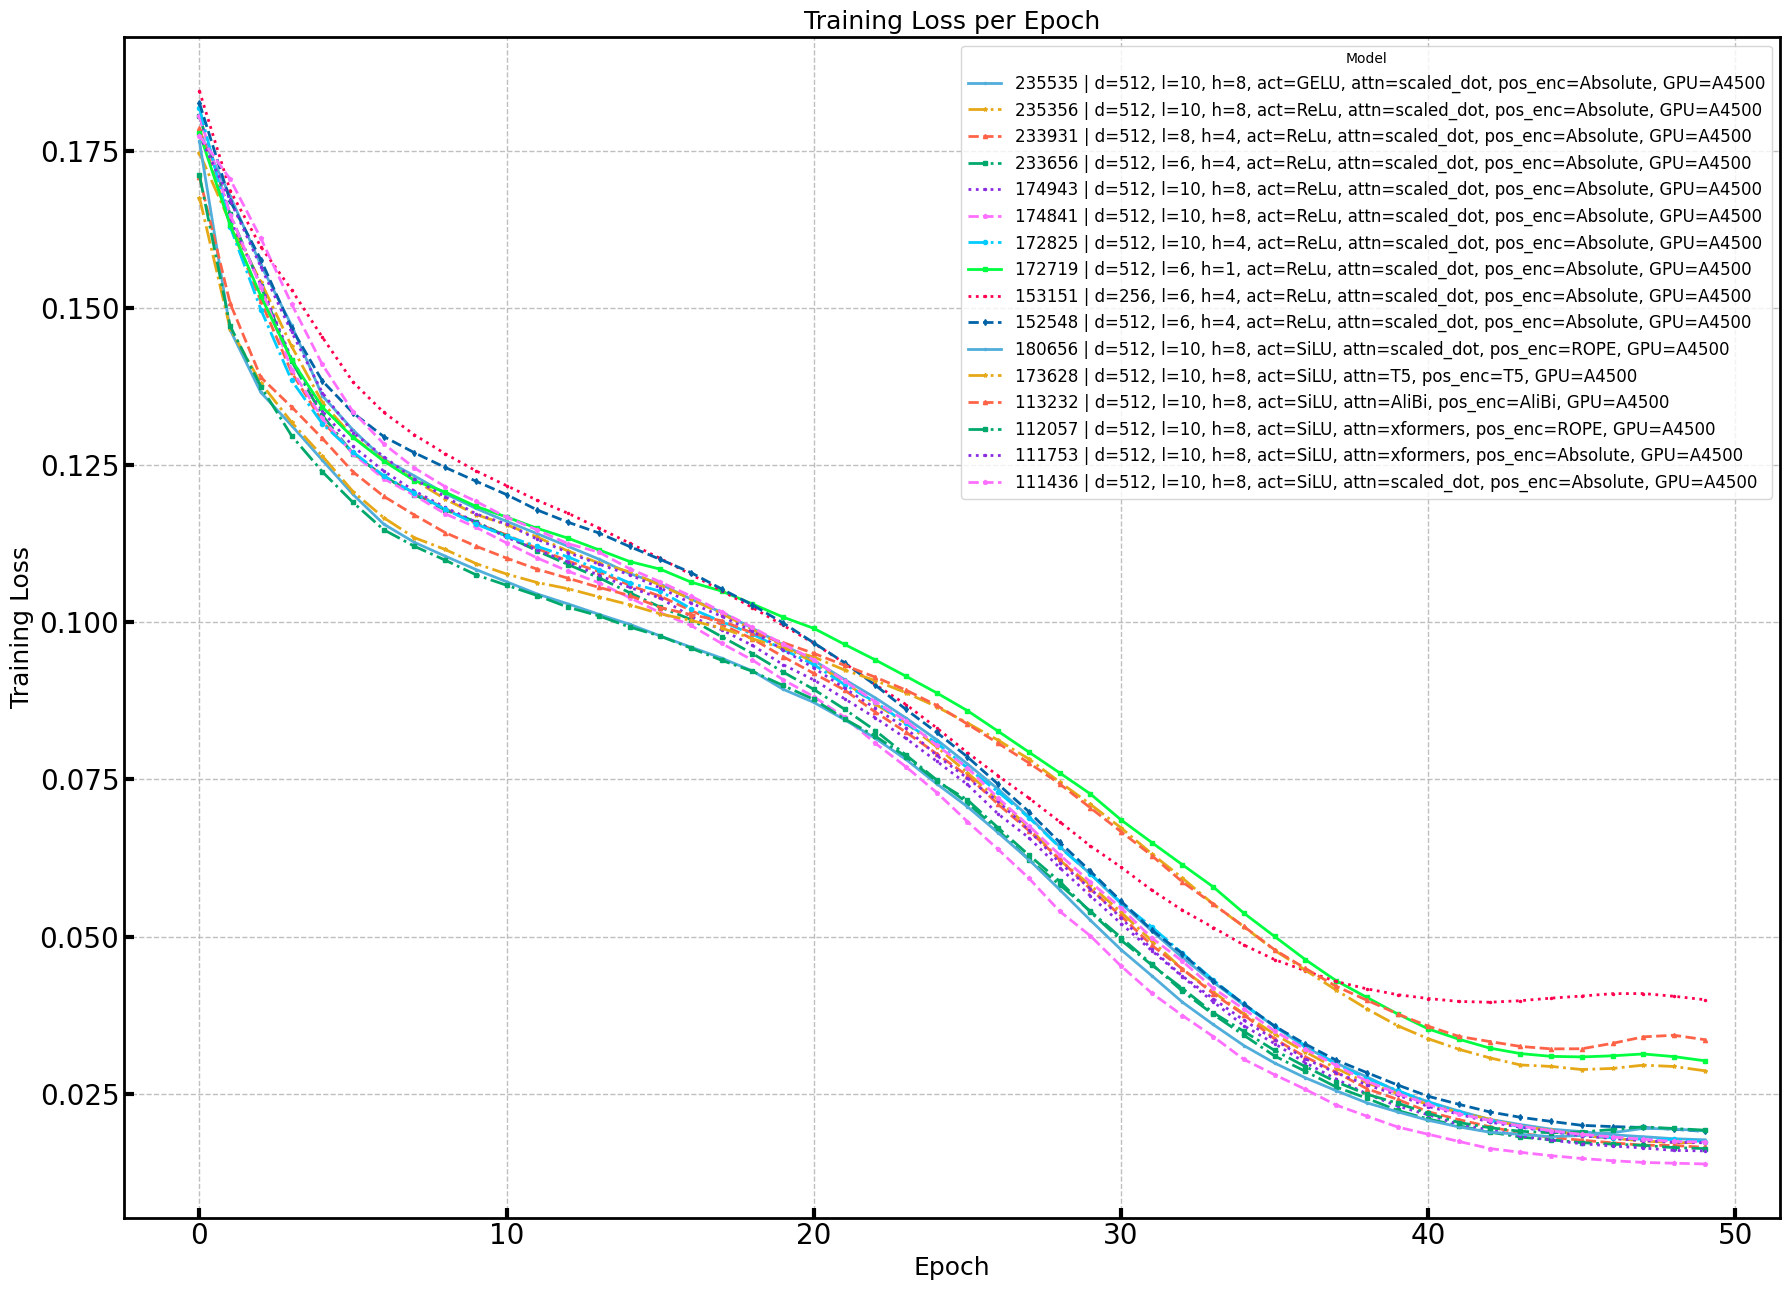

In [15]:
plot_train_loss(merged_train_loss, lookup_df=df_lookup)

In [16]:
def plot_validation_loss(merged_df: pd.DataFrame, lookup_df: pd.DataFrame, selected_id: list[str] = None):
    """
    Plot training loss over epochs with labels generated from training specs.
    """
    if selected_id is None:
        selected_id = merged_df.columns.tolist()

    fig, ax = plt.subplots(figsize=(18, 13))

    for id_ in selected_id:
        if id_ not in merged_df.columns:
            print(f"[Warning] ID {id_} not found in DataFrame columns. Skipping.")
            continue
        label = get_label(id_, lookup_df)
        ax.plot(merged_df.index, merged_df[id_], label=label)

    ax.set_title("Validation Loss per Epoch", fontsize=18)
    ax.set_xlabel("Epoch", fontsize=18)
    ax.set_ylabel("Validation Loss", fontsize=18)
    ax.legend(title="Model", fontsize=12)
    plt.tight_layout()
    plt.show()


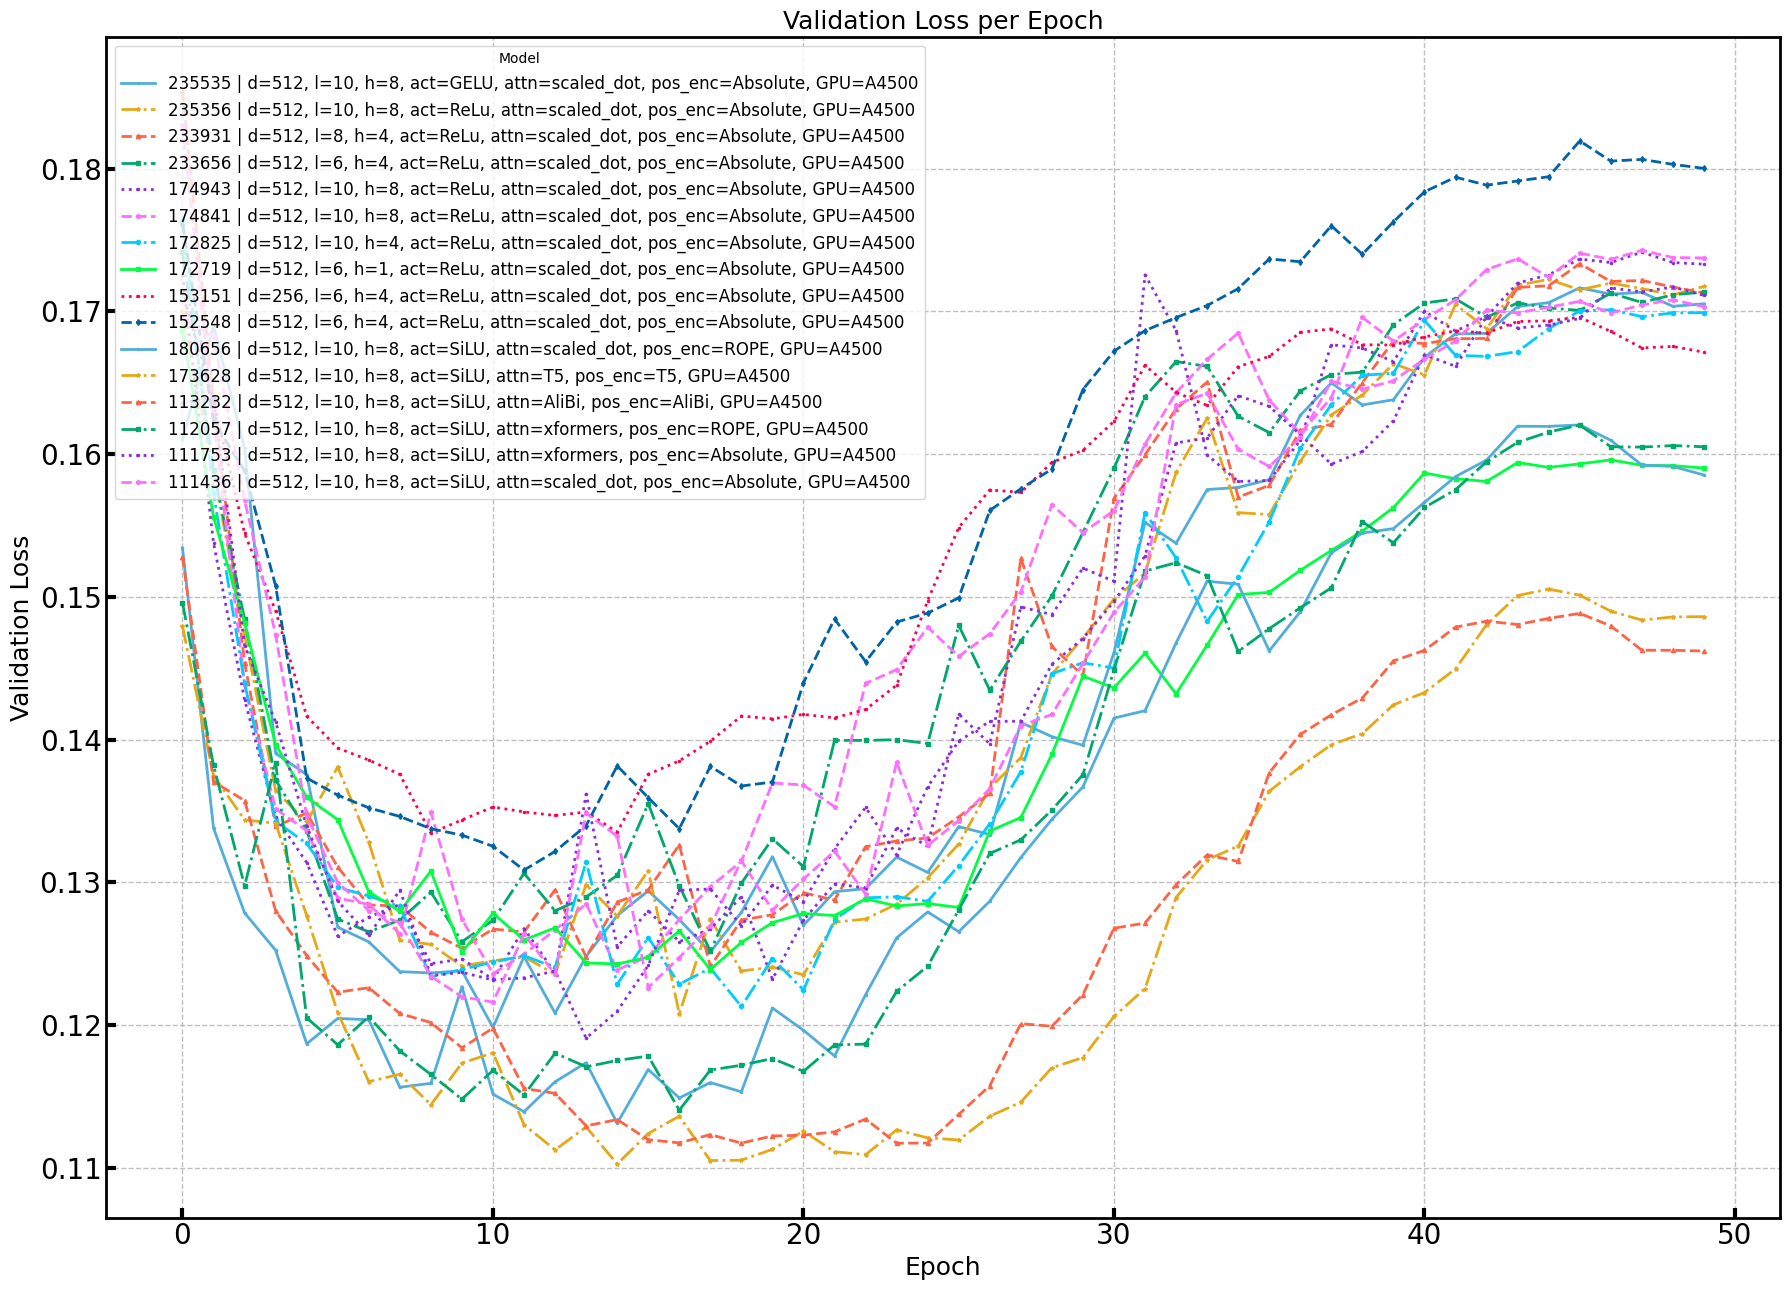

In [17]:
plot_validation_loss(merged_valid_loss, lookup_df=df_lookup)

In [18]:
def plot_train_validation_loss(merged_train_df: pd.DataFrame, 
                               merged_validation_df: pd.DataFrame,
                               lookup_df: pd.DataFrame,
                               selected_id: str):
    """
    Plot training loss over epochs with labels generated from training specs.
    """

    fig, ax = plt.subplots(figsize=(18, 13))
    label = get_label(selected_id, lookup_df)
    ax.plot(merged_train_df.index, merged_train_df[selected_id], label="Training los")
    ax.plot(merged_validation_df.index, merged_validation_df[selected_id], label="Validation loss", color = getColour(2))

    ax.set_title("Training and Validation Loss per Epoch", fontsize=18)
    ax.set_xlabel("Epoch", fontsize=18)
    ax.set_ylabel("Loss", fontsize=18)
    ax.legend(fontsize=22)
    plt.tight_layout()
    plt.show()


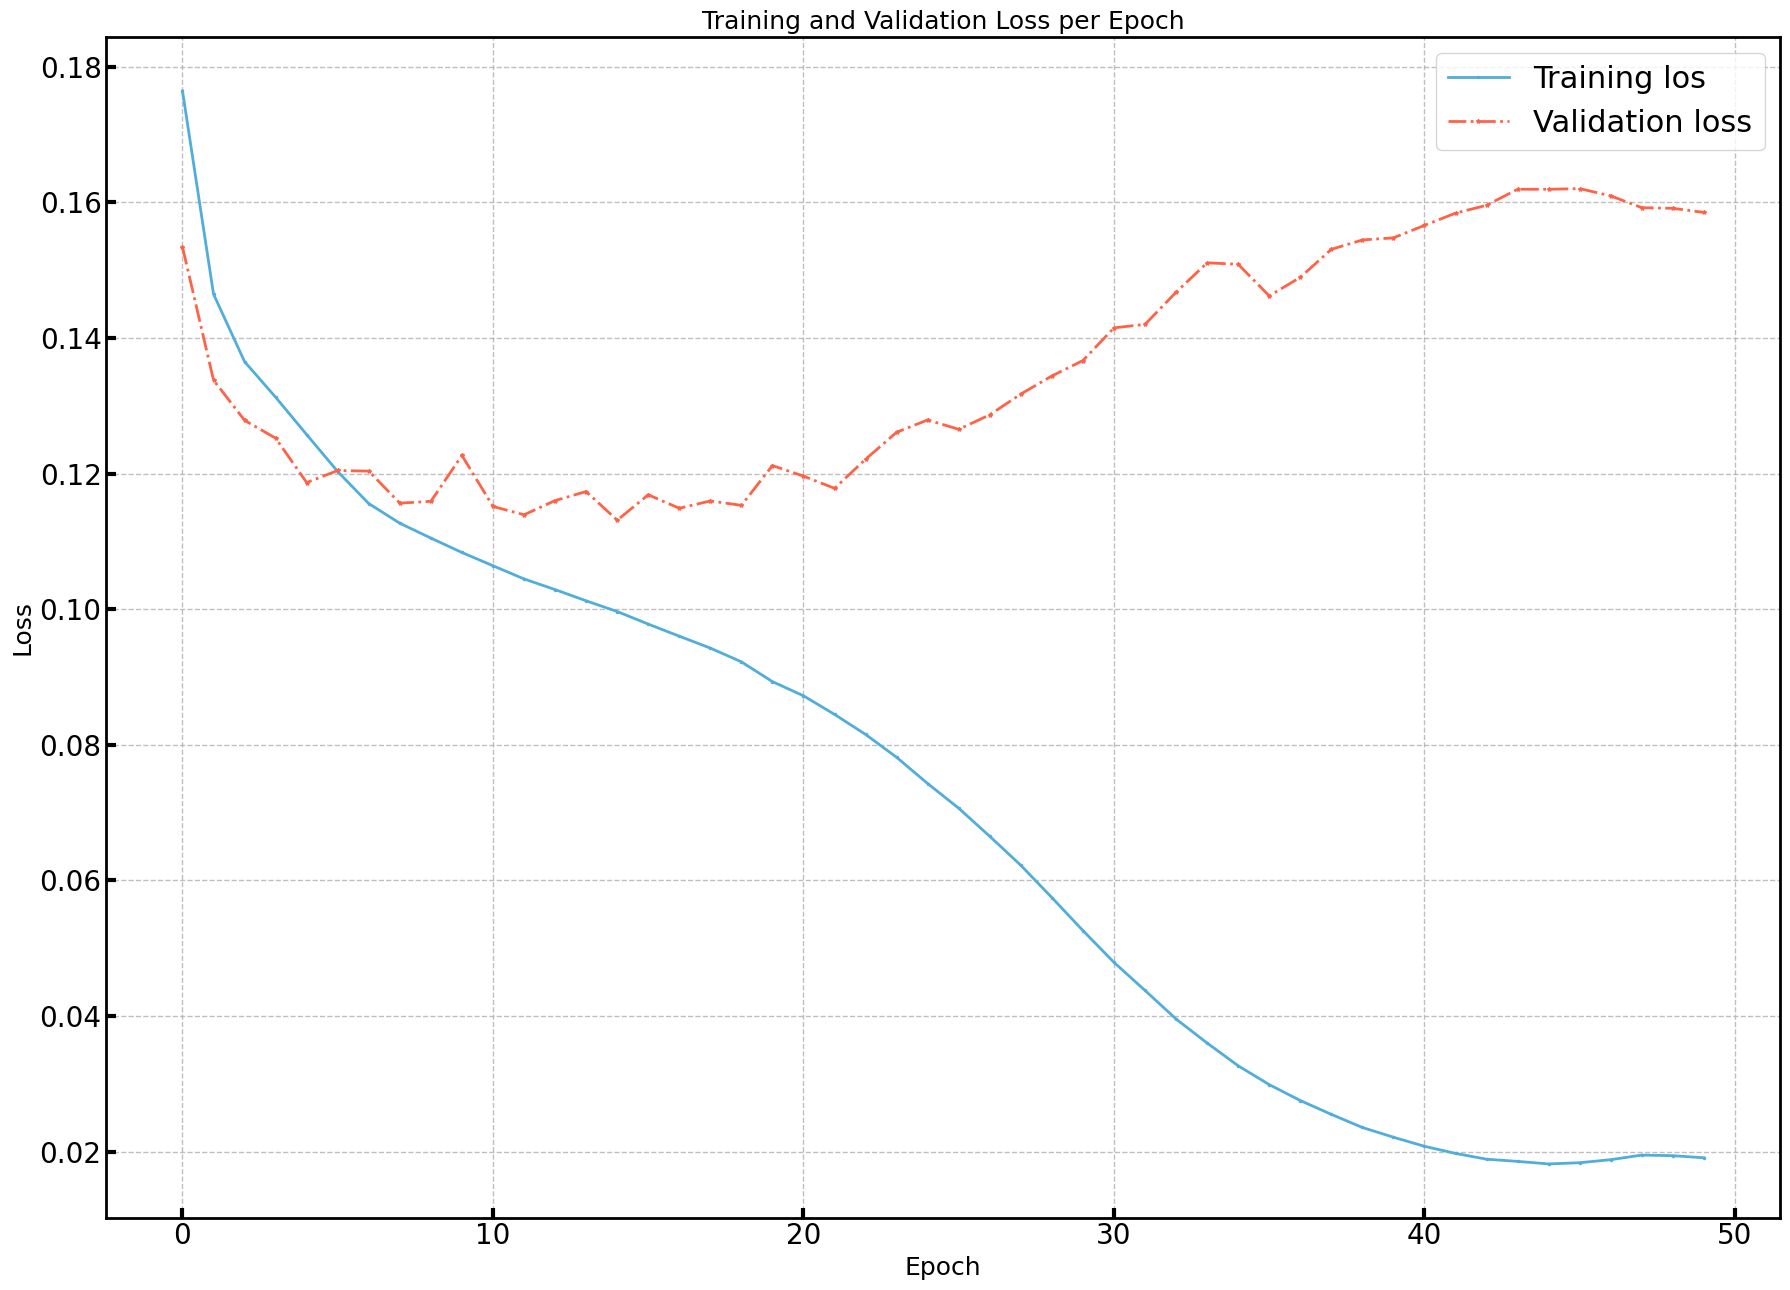

In [19]:
plot_train_validation_loss(
    merged_train_loss, merged_valid_loss, lookup_df=df_lookup, selected_id="180656"
)

In [44]:

def plot_onecycle_configs(configs, steps_per_epoch=100, epochs=10):
    fig, ax = plt.subplots(figsize=(17, 11))

    for cfg in configs:
        model = torch.nn.Linear(1, 1)  # dummy model
        optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)

        scheduler = OneCycleLR(
            optimizer,
            max_lr=cfg.get("max_lr", 0.1),
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            pct_start=cfg.get("pct_start", 0.3),
            anneal_strategy=cfg.get("anneal_strategy", 'cos'),
            div_factor=cfg.get("div_factor", 25.0),
            final_div_factor=cfg.get("final_div_factor", 1e4),
            three_phase=cfg.get("three_phase", False)
        )

        lrs = []
        for _ in range(steps_per_epoch * epochs):
            optimizer.step()
            lrs.append(optimizer.param_groups[0]['lr'])
            scheduler.step()

        label = cfg.get("label", str(cfg))
        ax.plot(lrs, label=label, linewidth=2)

    ax.set_title("OneCycleLR Learning Rate Schedules")
    ax.set_xlabel("Step", fontsize=22)
    ax.set_ylabel("Learning Rate", fontsize=22)
    ax.legend(fontsize=24)
    plt.tight_layout()
    plt.show()


In [49]:
configs = [
    {"max_lr": 1e-4, "pct_start": 0.1, "div_factor": 5, "final_div_factor": 100, "label": "max_lr(1e-4),pct_start(0.1), div(5), final(100)"},
    # {"max_lr": 3e-4, "pct_start": 0.1, "div_factor": 25, "final_div_factor": 100, "label": "max_lr(3e-4),pct_start(0.1), div(25), final(100)"},
    # {"max_lr": 1e-4, "pct_start": 0.3, "div_factor": 100, "final_div_factor": 1e4, "label": "max_lr(1e-4),pct_start(0.3), div(100), final(1e4)"},
    # {"max_lr": 3e-4, "pct_start": 0.05, "div_factor": 100, "final_div_factor": 1e4, "label": "max_lr(3e-4),pct_start(0.05), div(100), final(1e4)"},
]

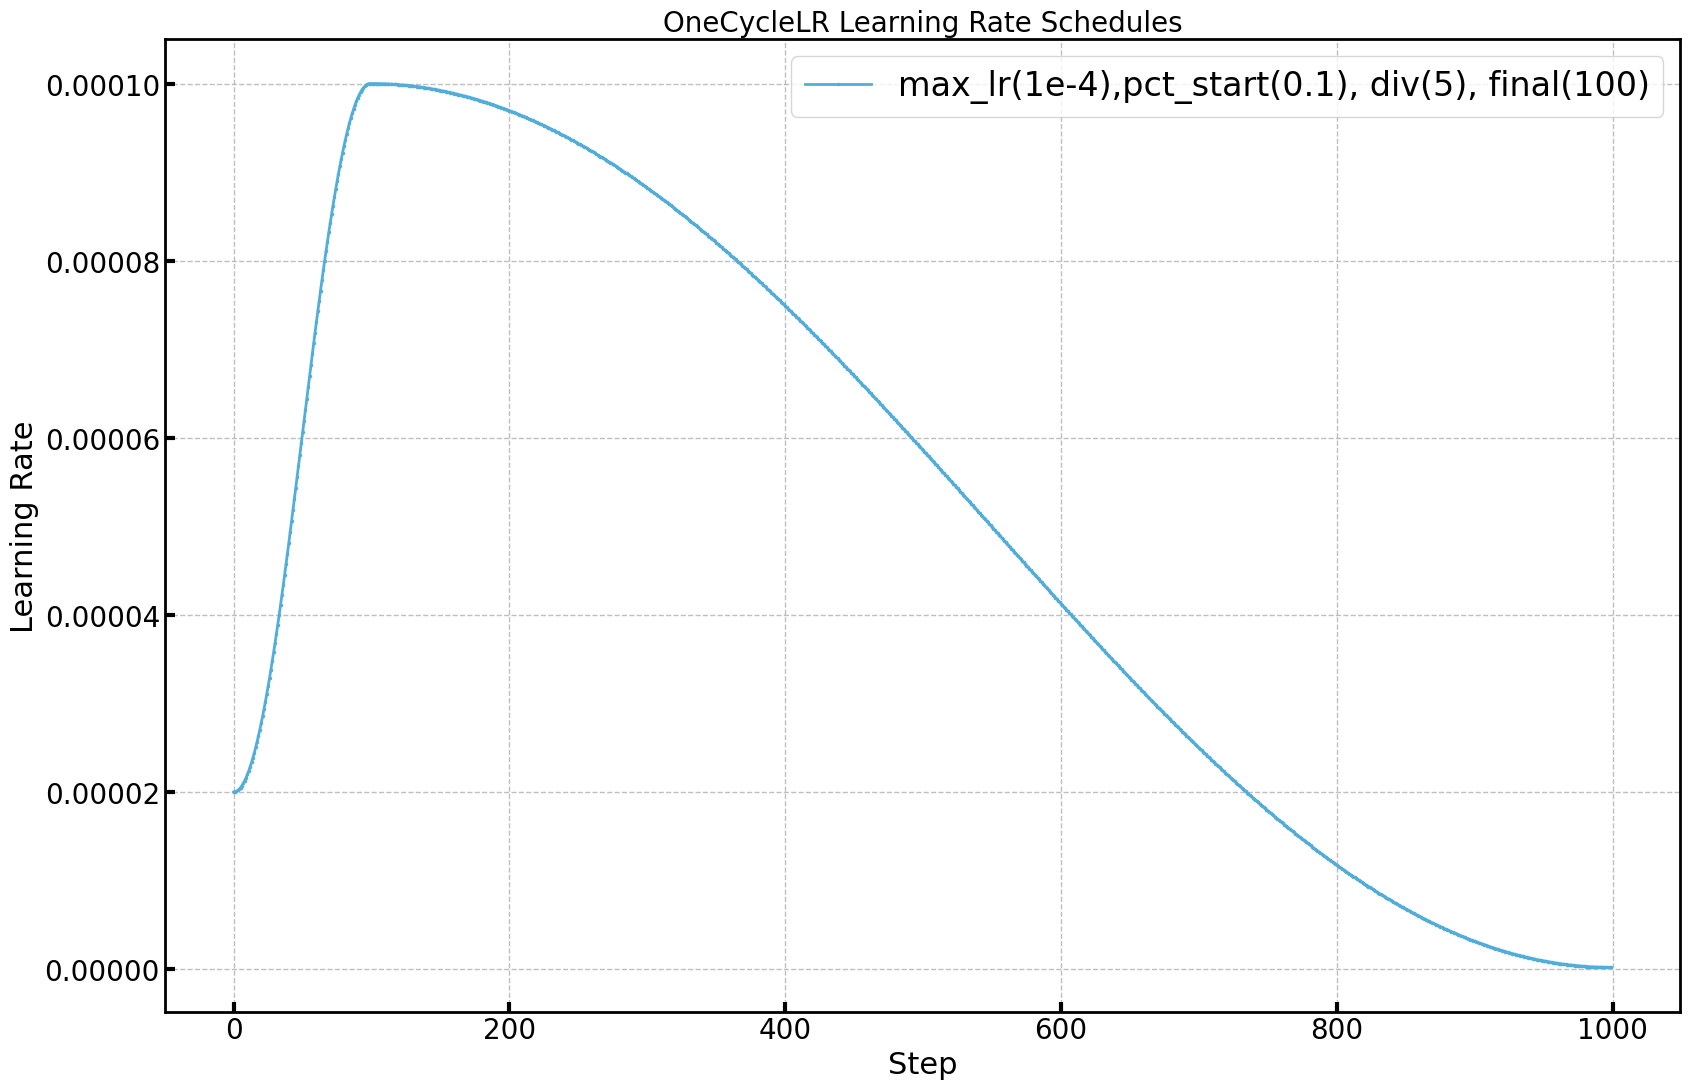

In [50]:
plot_onecycle_configs(configs, steps_per_epoch=100, epochs=10)